# Simulation of Clustered-Input on Dendritic Segments 

In [1]:
from scipy import stats

from cell_template import Cell, BRANCH_COLORS
from clustered_input_stim import * 
from parallel import Parallel

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

# Basket Cell

## Visualizing the Distant-Dependent Clusters

In [2]:
distance_intervals  = [[20,60], 
                       [160,200]]

def show_cluster(cell, iDistance, label, sparsening=5.):
    
    props ={'iDistance':iDistance, # 2 -> means "distal" range
            'distance_intervals':distance_intervals,
            'synSubsamplingFraction':sparsening/100.}

    fig, AX = pt.figure(figsize=(1.7,2.5), axes=(2, 6), hspace=0.2, wspace=0., left=0.3)
    
    for iBranch in range(6):
        c, INSETS = BRANCH_COLORS[iBranch], []
        pt.annotate(AX[iBranch][0], 'branch #%i' % (1+iBranch), (-1, 0.5), color=c)
        _, inset = find_clustered_input(cell, iBranch, **props,
                            with_plot=True, ax=AX[iBranch][0], syn_color=c)
        INSETS.append(inset)
        _, inset = find_clustered_input(cell, iBranch, from_uniform=True, **props,
                            with_plot=True, syn_color=c, ax=AX[iBranch][1])
        INSETS.append(inset)
        pt.annotate(AX[iBranch][0], 'real', (-0.3,0.3), bold=True, color=c)
        pt.annotate(AX[iBranch][1], 'uniform', (-0.3,0.3), bold=True, color=c)

        pt.set_common_ylims(INSETS)
    fig.suptitle('**%s cluster**,  interval: %s um' % (label, str(distance_intervals[iDistance])))
    return fig

### Basket Cell

In [ ]:
# load cell:            (need to Restart the Kernel when changing cell !)
ID = '864691135396580129_296758' # Basket Cell example
cell = Cell(ID=ID, params_key='BC')

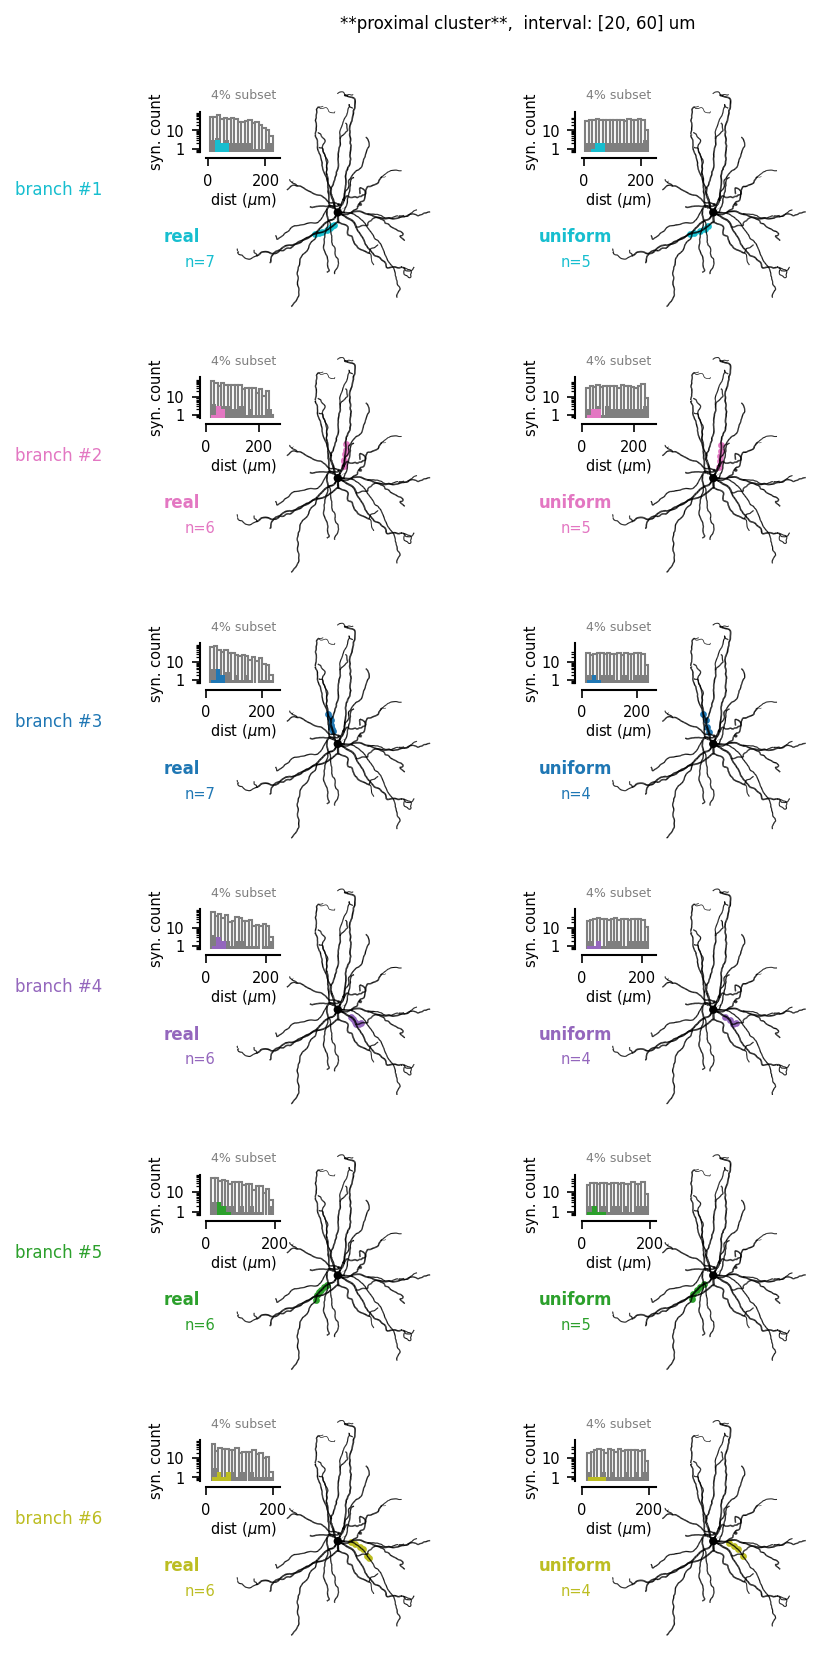

In [4]:
fig = show_cluster(cell, 0, 'proximal', sparsening=4.)
fig.savefig('../../figures/detailed_model/cluster-proximal-BC.svg')

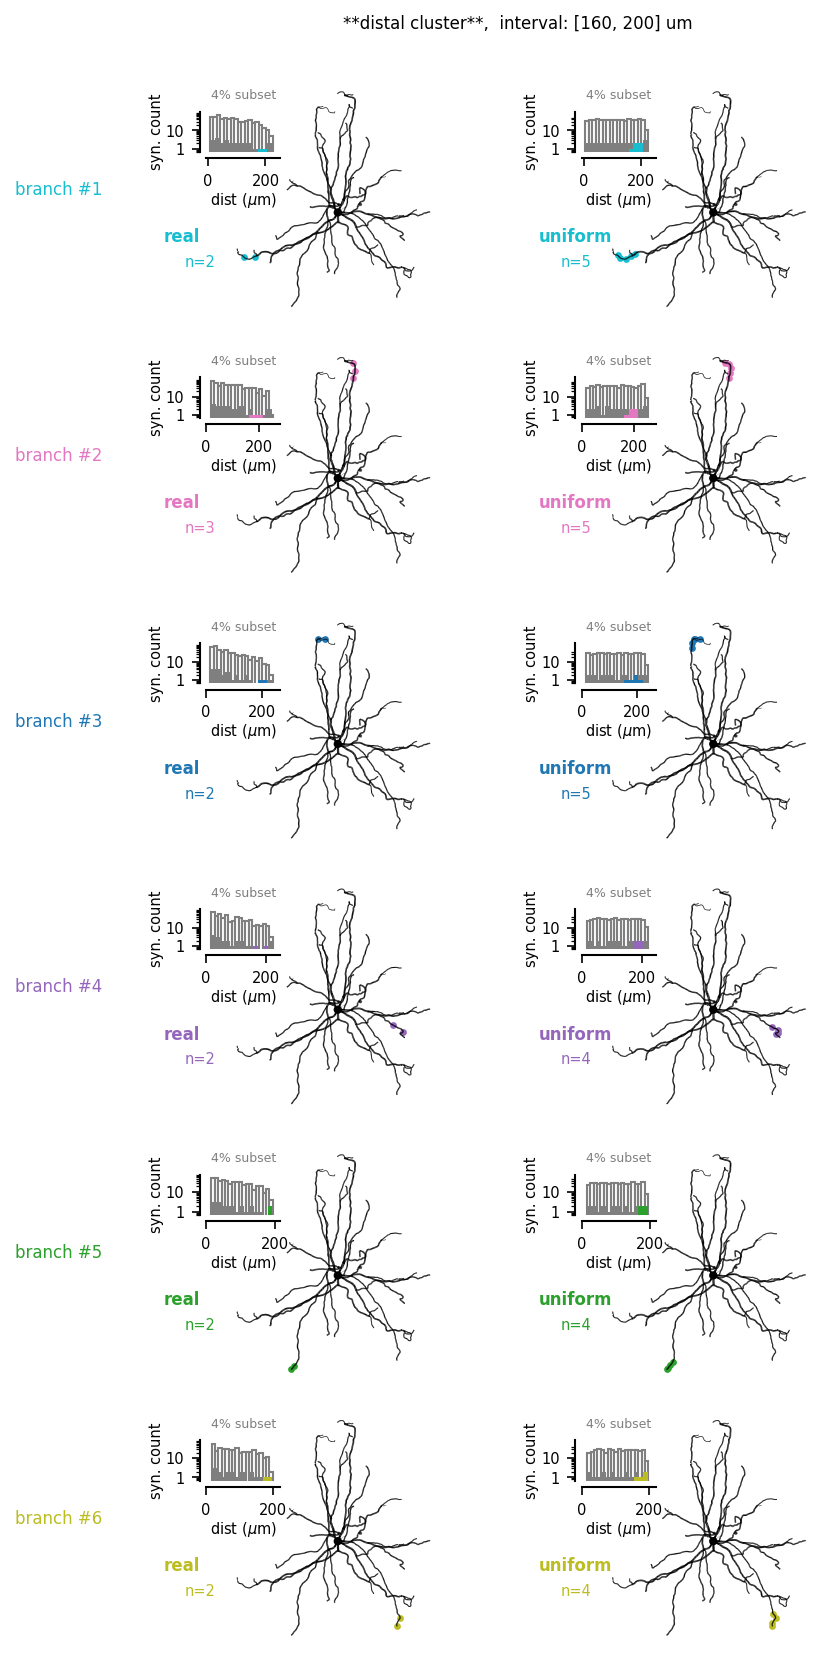

In [5]:
fig = show_cluster(cell, 1, 'distal', sparsening=4.)
fig.savefig('../../figures/detailed_model/cluster-distal-BC.svg')

### Martinotti Cell

In [3]:
# load cell:            (need to Restart the Kernel when changing cell !)
ID = '864691135571546917_264824' # Martinotti Cell example
cell = Cell(ID=ID, params_key='MC')

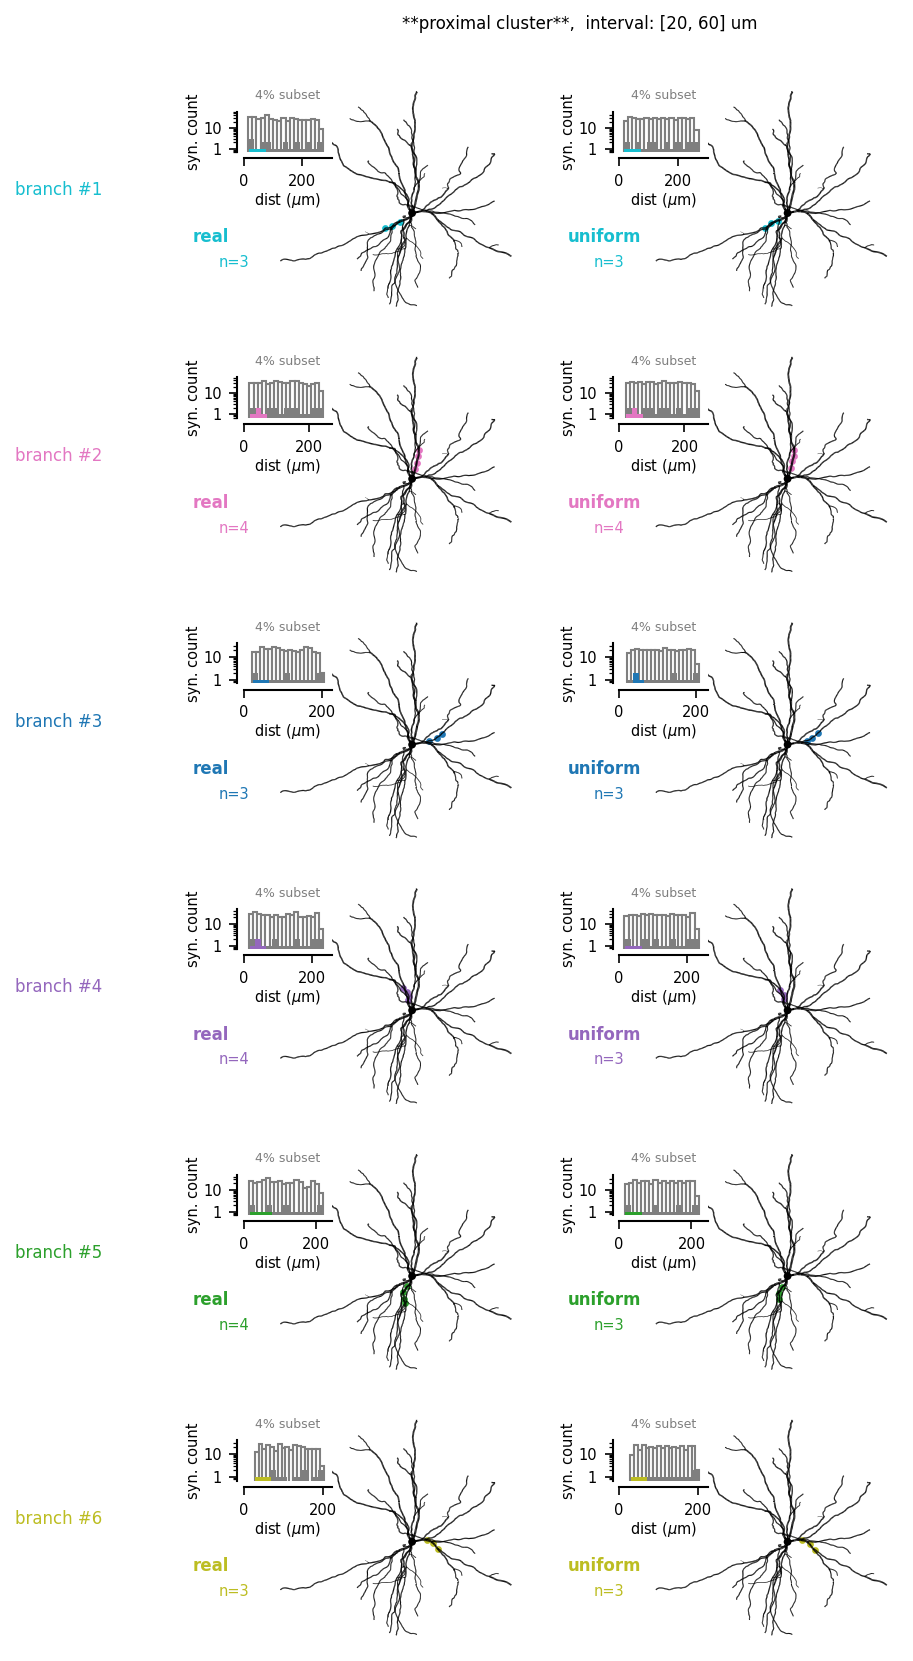

In [5]:
fig = show_cluster(cell, 0, 'proximal', sparsening=4.)
fig.savefig('../../figures/detailed_model/cluster-proximal-MC.svg')

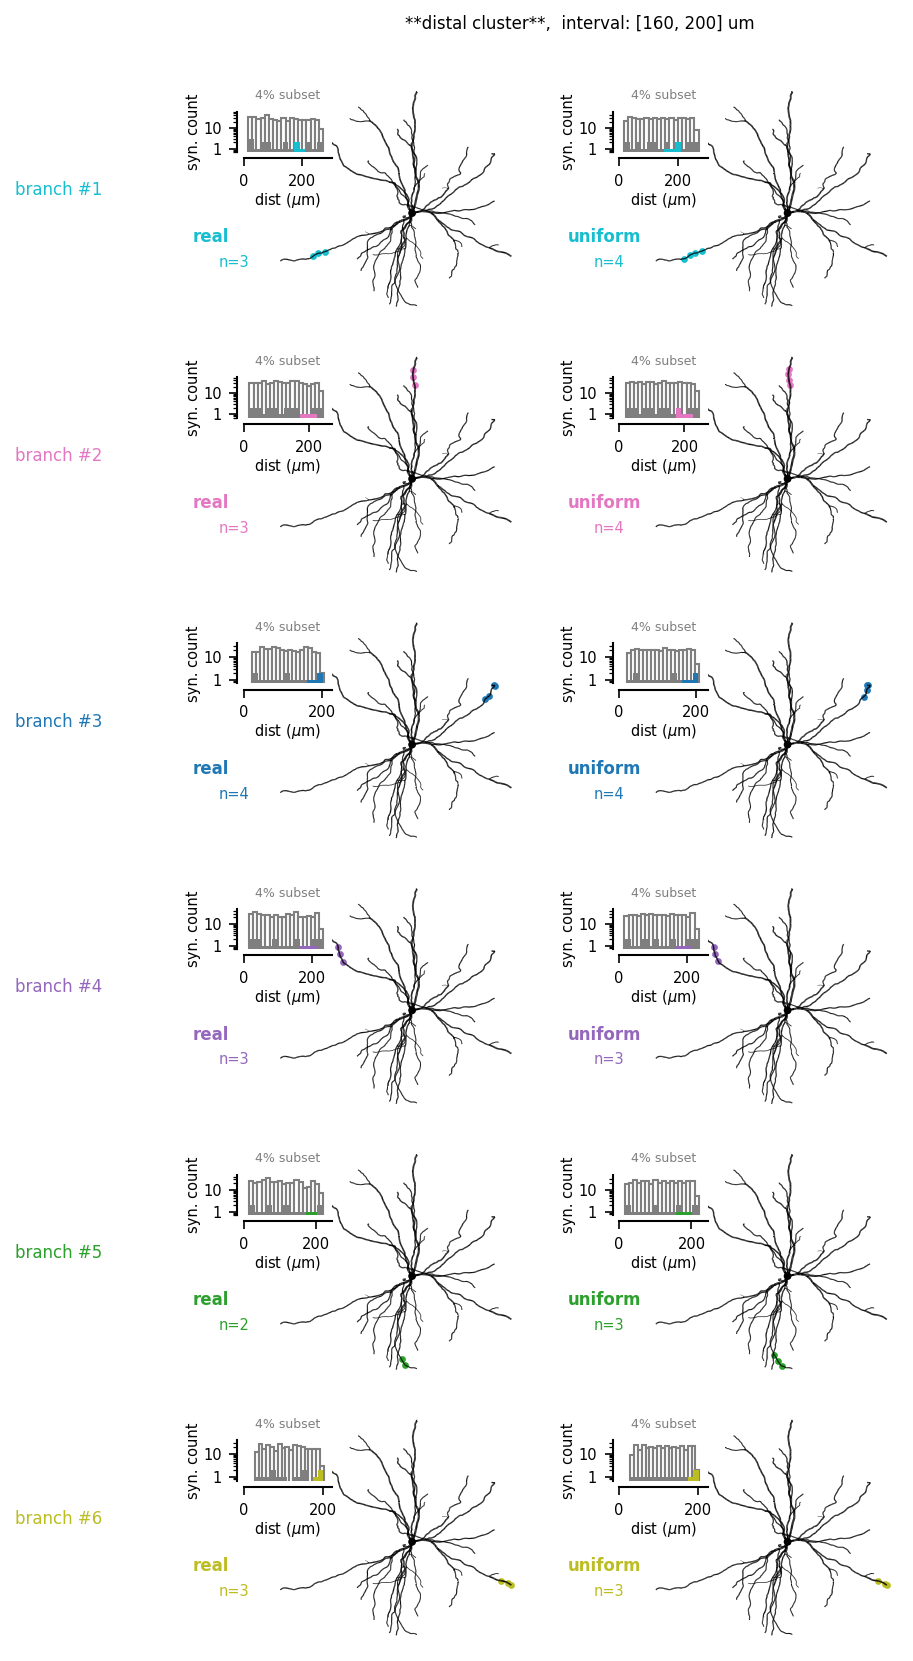

In [6]:
fig = show_cluster(cell, 1, 'distal', sparsening=4.)
fig.savefig('../../figures/detailed_model/cluster-distal-MC.svg')

## Perform Simulations

N.B. **passive only** simulation settings

### Example Simulation

```
python clustered_input_stim.py --test
```

#### Visualize Example Simulation

Made of single synapse stimulation events + a stimulation pattern all together

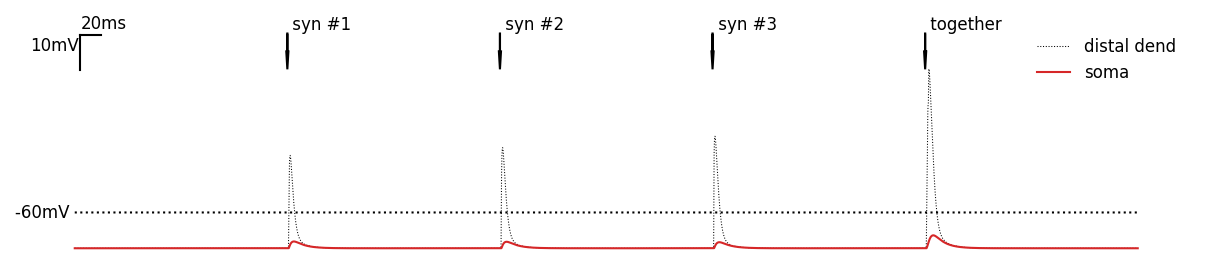

In [22]:
import numpy as np
results = np.load('single_sim.npy', allow_pickle=True).item()

t = np.arange(len(results['Vm_soma']))*results['dt']
fig, ax = pt.figure(figsize=(3,2.5), left=0, bottom=0.)

for i, syn in enumerate(results['synapses']):
    pt.arrow(ax, [results['t0']+i*results['ISI'], -10, 0, -10],
             head_width=2, head_length=5, width=0.1)
    pt.annotate(ax, ' syn #%i' % (i+1), (results['t0']+i*results['ISI'], -10), xycoords='data')
pt.arrow(ax, [results['t0']+(i+1)*results['ISI'], -10, 0, -10],
         head_width=2, head_length=5, width=0.1)
pt.annotate(ax, ' together', (results['t0']+(i+1)*results['ISI'], -10), xycoords='data')

ax.plot(t, results['Vm_dend'], 'k:', lw=0.5, label='distal dend')
ax.plot(t, results['Vm_soma'], 'tab:red', label='soma')
ax.plot(t, -60+0*t, 'k:')
pt.annotate(ax, '-60mV ', (0,-60), xycoords='data', ha='right', va='center')

ax.axis('off')
pt.draw_bar_scales(ax, Xbar=20, Xbar_label='20ms', Ybar=10, Ybar_label='10mV')
ax.legend(frameon=False, loc='best')

#### Compare Real Response to Linear Prediction from Arithmetic Sum of Individual Responses

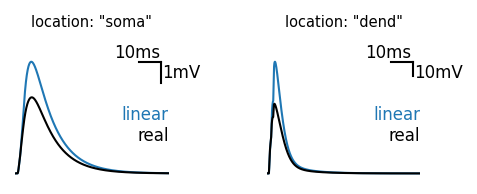

In [53]:
t = np.arange(len(results['linear_soma']))*results['dt']
fig, AX = pt.figure(axes=(2,1), figsize=(1.1,1.3), left=0, bottom=0.)

for ax, loc, ys in zip(AX, ['soma', 'dend'], [1, 10]):
    for r, resp, c in zip(range(2), ['linear', 'real'], ['tab:blue', 'k']):
        ax.plot(t, results['%s_%s' % (resp, loc)], color=c)
        pt.annotate(ax, r*'\n'+resp, (1., 0.6), ha='right', va='top', color=c)
    ax.axis('off')
    ax.set_xlim([0, 70])
    pt.draw_bar_scales(ax, Xbar=10, Xbar_label='10ms', 
                       Ybar=ys, Ybar_label='%imV'%ys, loc='top-right')
    ax.set_title('location: "%s"\n' % loc, fontsize=7)

### Full Simulation Data

Execute the following command:
```
python clustered_input_stim.py -c Basket --test_uniform --sparsening 3 4 5 6 7 8 9 10

```


## Loading Simulated Data

In [54]:
sim = Parallel(\
        filename='../../data/detailed_model/clusterStim_sim_Basket.zip')
sim.load()

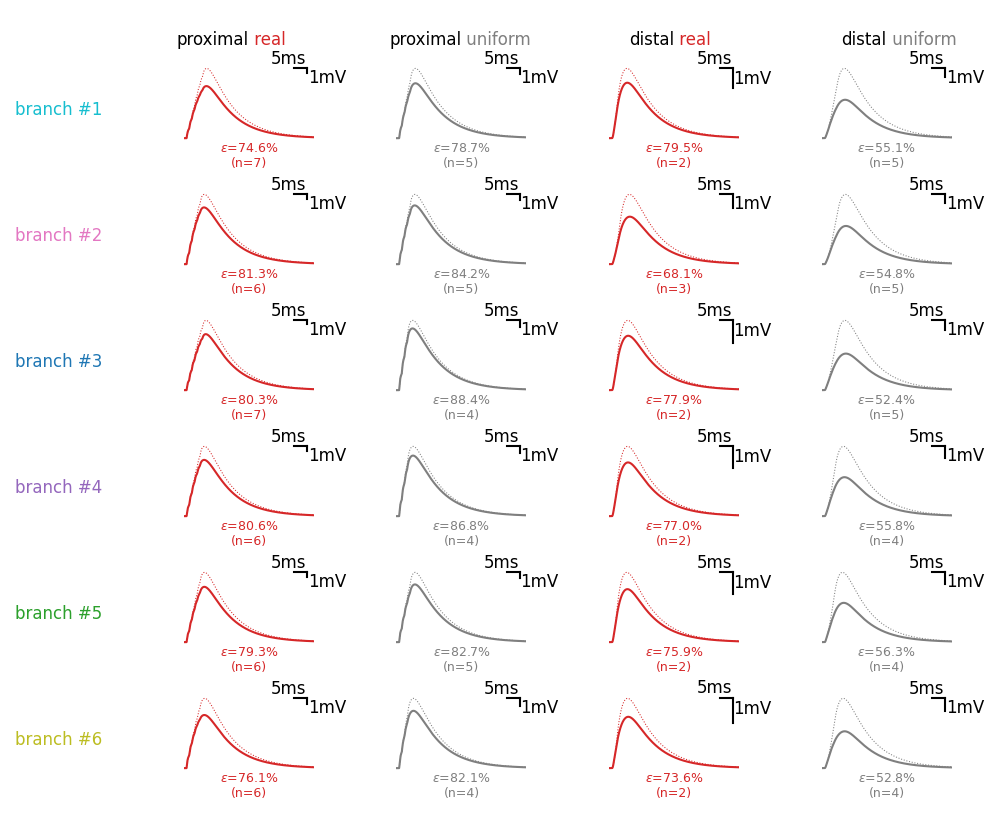

In [55]:
loc, based_on = 'soma', 'peak'
sparsening = 4.0

sim.fetch_quantity_on_grid('linear_%s' % loc, dtype=list)
sim.fetch_quantity_on_grid('real_%s' % loc, dtype=list)
sim.fetch_quantity_on_grid('%s_efficacy_%s' % (based_on, loc), dtype=float)
sim.fetch_quantity_on_grid('synapses', dtype=list)
dt = sim.fetch_quantity_on_grid('dt', return_last=True)

fig, AX = pt.figure(axes=(2*len(np.unique(sim.iDistance)),
                          len(np.unique(sim.iBranch))))
plt.subplots_adjust(top=.8)
pt.annotate(fig, 'sparsening: X%%\n\n', (0.5, .79), ha='center', xycoords='figure fraction')

CONDS = ['proximal', 'distal']
COLORS, LABELS = ['tab:red', 'tab:grey'], [' real', ' uniform']
    
for iDistance in np.unique(sim.iDistance):
    for iBranch in np.unique(sim.iBranch):
        params = {'iDistance':iDistance, 'iBranch':iBranch, 'synSubsamplingFraction':sparsening/100.}
        for f, fU in enumerate([False, True]):
            real = sim.get('real_%s' % loc, dict(from_uniform=fU, **params))[0]
            linear = sim.get('linear_%s' % loc, dict(from_uniform=fU, **params))[0]
            t = np.arange(len(real))*dt
            AX[iBranch][2*iDistance+f].plot(t, real, '-', color=COLORS[f])
            AX[iBranch][2*iDistance+f].plot(t, linear, ':', color=COLORS[f], lw=0.5)
            n = len(sim.get('synapses', dict(from_uniform=fU, **params))[0])
            pt.annotate(AX[iBranch][2*iDistance+f], 
                        '$\epsilon$=%.1f%%\n(n=%i)' % (sim.get('%s_efficacy_%s' % (based_on, loc),
                                                      dict(from_uniform=fU, **params))[0], n),
                        (0.5,0), va='top', ha='center', color=COLORS[f], fontsize=6)
            
            pt.set_plot(AX[iBranch][2*iDistance+f], [], xlim=[0,50])
            pt.draw_bar_scales(AX[iBranch][2*iDistance+f], loc='top-right',
                               Xbar=5, Xbar_label='5ms',
                               Ybar=1 if loc=='soma' else 10,
                               Ybar_label='1mV' if loc=='soma' else '10mV')
            if iBranch==0:
                pt.annotate(AX[0][2*iDistance+f], CONDS[iDistance], (0.5,1.2), ha='right')
                pt.annotate(AX[0][2*iDistance+f], LABELS[f], (0.5,1.2), color=COLORS[f])
    
        if iDistance==0:
            pt.annotate(AX[iBranch][iDistance], 'branch #%i' % (iBranch+1),
                        (-1.3,0.3), color=BRANCH_COLORS[iBranch])
    
fig.savefig('../../figures/detailed_model/cluster-single-traces-BC.svg')

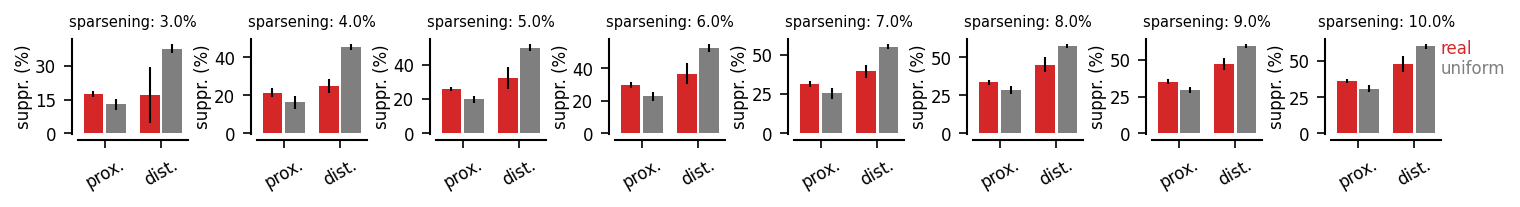

In [56]:
# plot across different sparsening levels

based_on = 'peak_efficacy_soma' # summary quantity to plot

sim.fetch_quantity_on_grid(based_on, dtype=float)

COLORS, LABELS = ['tab:red', 'tab:grey'], ['real', 'uniform']

fig, AX = pt.figure(axes=(len(np.unique(sim.synSubsamplingFraction)),1),
                    figsize=(.9, 1), reshape_axes=False)

for i, frac in enumerate(np.unique(sim.synSubsamplingFraction)):
    AX[0][i].set_title('sparsening: %.1f%%' % (100*frac), fontsize=7)
    for f, fU in enumerate([False, True]):
        for iDistance in np.unique(sim.iDistance):
            params = dict(iDistance=iDistance, from_uniform=fU, synSubsamplingFraction=frac)
            AX[0][i].bar([iDistance+0.4*f], [100-np.mean(sim.get(based_on, params))],
                   yerr=[np.nanstd(sim.get(based_on, params))], color=COLORS[f], width=0.35)
        if i==0:
            pt.annotate(AX[0][-1], f*'\n'+LABELS[f], (1,1), va='top', color=COLORS[f])
    pt.set_plot(AX[0][i], ylabel='suppr. (%)',# ylabel='efficacy (%)',
                xticks=0.2+np.arange(2), xticks_labels=['prox.', 'dist.'],
                xticks_rotation=30)

## Suppression Effect


 statistics on the distal/prox ratios:

- Wilcoxon:        WilcoxonResult(statistic=0.0, pvalue=0.03125)
- Paired t-test:   TtestResult(statistic=-6.087779856352894, pvalue=0.0017297931354738063, df=5)


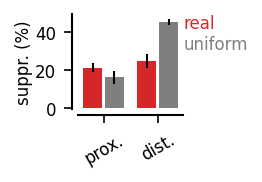

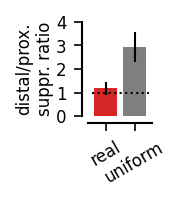

In [57]:
sparsening = 4.0

fig1, ax1 = pt.figure(figsize=(.9, 1))
fig2, ax2 = pt.figure(figsize=(.7, 1))

Xs = []
for f, fU in enumerate([False, True]):
    # suppression
    for iDistance in np.unique(sim.iDistance):
        params = dict(iDistance=iDistance, from_uniform=fU, synSubsamplingFraction=sparsening/100.)
        ax1.bar([iDistance+0.4*f], [100-np.mean(sim.get(based_on, params))],
               yerr=[np.std(sim.get(based_on, params))], color=COLORS[f], width=0.35)
    # suppression ratios
    pProx = dict(iDistance=0, from_uniform=fU, synSubsamplingFraction=sparsening/100.)
    pDist = dict(iDistance=1, from_uniform=fU, synSubsamplingFraction=sparsening/100.)
    X = (100-sim.get(based_on, pDist))/(100-sim.get(based_on, pProx))
    ax2.bar([f], [np.mean(X)], yerr=[np.std(X)], color=COLORS[f])#, width=0.5)
    pt.annotate(ax1, f*'\n'+LABELS[f], (1,1), va='top', color=COLORS[f])
    Xs.append(X)
    
print('\n statistics on the distal/prox ratios:\n')
print('- Wilcoxon:       ', stats.wilcoxon(*Xs))
print('- Paired t-test:  ', stats.ttest_rel(*Xs))

pt.set_plot(ax1, ylabel='suppr. (%)',
            xticks=0.2+np.arange(2), xticks_labels=['prox.', 'dist.'],
            xticks_rotation=30)

ax2.plot([-0.5,1.5], [1,1], 'k:')
pt.set_plot(ax2, ylabel='distal/prox.\nsuppr. ratio',
            xticks=np.arange(2), xticks_labels=['real', 'uniform'],
            yticks=[0,1,2,3,4],  ylim=[0,4],
            xticks_rotation=30)

fig1.savefig('../../figures/detailed_model/cluster-suppression-prox-dist-BC.svg')
fig2.savefig('../../figures/detailed_model/cluster-suppression-ratio-BC.svg')

# Martinotti Cell

In [3]:
from parallel import Parallel

sim = Parallel(\
        filename='../../data/detailed_model/clusterStim_sim_Martinotti.zip')

sim.load()

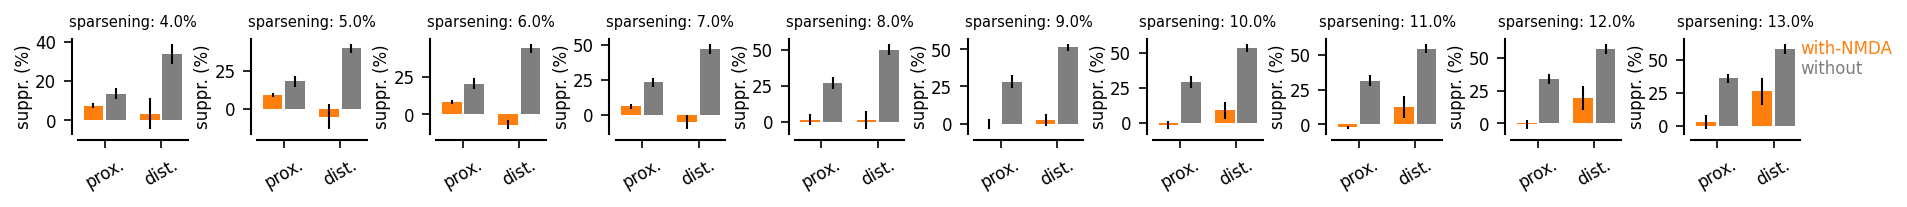

In [8]:
# plot across different sparsening levels
import numpy as np

based_on = 'peak_efficacy_soma' # summary quantity to plot

sim.fetch_quantity_on_grid(based_on, dtype=float)

COLORS, LABELS = ['tab:orange', 'tab:grey'], ['with-NMDA', 'without']

fig, AX = pt.figure(axes=(len(np.unique(sim.synSubsamplingFraction)),1),
                    figsize=(.9, 1), reshape_axes=False)

for i, frac in enumerate(np.unique(sim.synSubsamplingFraction)):
    AX[0][i].set_title('sparsening: %.1f%%' % (100*frac), fontsize=7)
    for f, wN in enumerate([True, False]):
        for iDistance in np.unique(sim.iDistance):
            params = dict(iDistance=iDistance, with_NMDA=wN, synSubsamplingFraction=frac)
            AX[0][i].bar([iDistance+0.4*f], [100-np.mean(sim.get(based_on, params))],
                   yerr=[np.nanstd(sim.get(based_on, params))], color=COLORS[f], width=0.35)
        if i==0:
            pt.annotate(AX[0][-1], f*'\n'+LABELS[f], (1,1), va='top', color=COLORS[f])
    pt.set_plot(AX[0][i], ylabel='suppr. (%)',# ylabel='efficacy (%)',
                xticks=0.2+np.arange(2), xticks_labels=['prox.', 'dist.'],
                xticks_rotation=30)

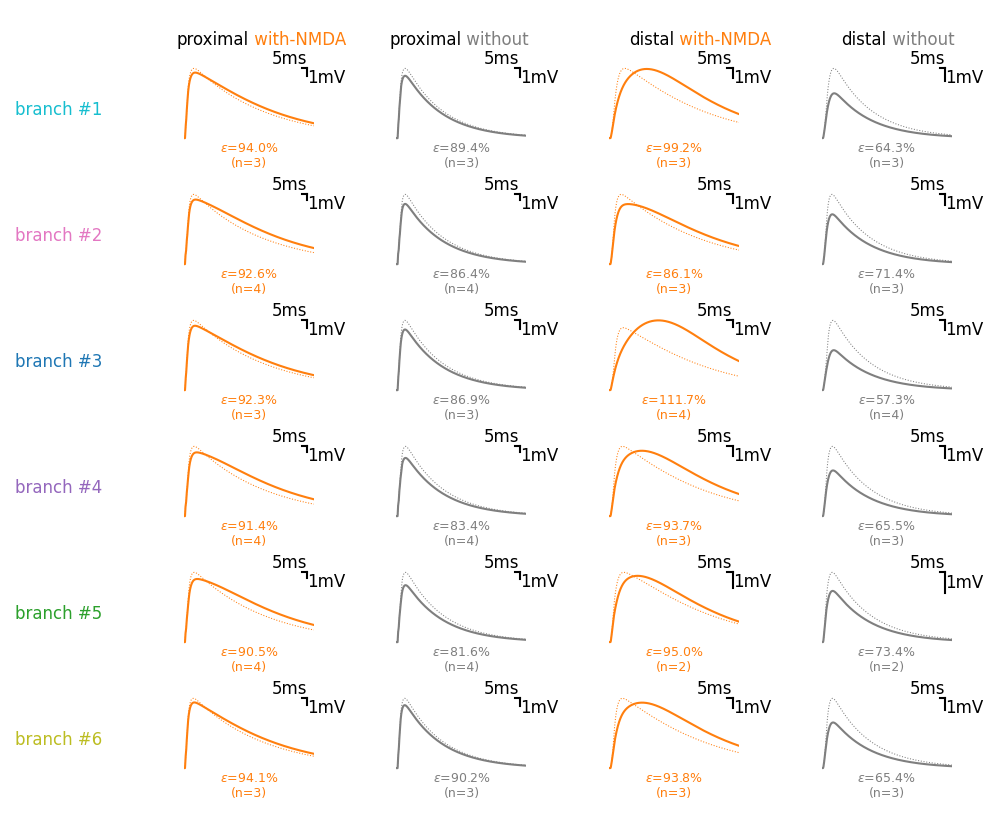

In [9]:
loc, based_on = 'soma', 'peak'
sparsening = 4.0

sim.fetch_quantity_on_grid('linear_%s' % loc, dtype=list)
sim.fetch_quantity_on_grid('real_%s' % loc, dtype=list)
sim.fetch_quantity_on_grid('%s_efficacy_%s' % (based_on, loc), dtype=float)
sim.fetch_quantity_on_grid('synapses', dtype=list)
dt = sim.fetch_quantity_on_grid('dt', return_last=True)

fig, AX = pt.figure(axes=(2*len(np.unique(sim.iDistance)),
                          len(np.unique(sim.iBranch))))
plt.subplots_adjust(top=.8)
pt.annotate(fig, 'sparsening: X%%\n\n', (0.5, .79), ha='center', xycoords='figure fraction')

CONDS = ['proximal', 'distal']
COLORS, LABELS = ['tab:orange', 'tab:grey'], [' with-NMDA', ' without']
    
for iDistance in np.unique(sim.iDistance):
    for iBranch in np.unique(sim.iBranch):
        for f, label, color in zip([0,1], LABELS, COLORS):
            params = {'iDistance':iDistance,
                      'iBranch':iBranch,
                      'synSubsamplingFraction':sparsening/100.,
                      'with_NMDA':(label==LABELS[0])}
            real = sim.get('real_%s' % loc, params)[0]
            linear = sim.get('linear_%s' % loc, params)[0]
            t = np.arange(len(real))*dt
            AX[iBranch][2*iDistance+f].plot(t, real, '-', color=COLORS[f])
            AX[iBranch][2*iDistance+f].plot(t, linear, ':', color=COLORS[f], lw=0.5)
            n = len(sim.get('synapses', params)[0])
            pt.annotate(AX[iBranch][2*iDistance+f], 
                        '$\epsilon$=%.1f%%\n(n=%i)' % (sim.get('%s_efficacy_%s' % (based_on, loc),
                                                      params)[0], n),
                        (0.5,0), va='top', ha='center', color=COLORS[f], fontsize=6)
            
            pt.set_plot(AX[iBranch][2*iDistance+f], [], xlim=[0,120])
            pt.draw_bar_scales(AX[iBranch][2*iDistance+f], loc='top-right',
                               Xbar=5, Xbar_label='5ms',
                               Ybar=1 if loc=='soma' else 10,
                               Ybar_label='1mV' if loc=='soma' else '10mV')
            if iBranch==0:
                pt.annotate(AX[0][2*iDistance+f], CONDS[iDistance], (0.5,1.2), ha='right')
                pt.annotate(AX[0][2*iDistance+f], LABELS[f], (0.5,1.2), color=COLORS[f])
    
        if iDistance==0:
            pt.annotate(AX[iBranch][iDistance], 'branch #%i' % (iBranch+1),
                        (-1.3,0.3), color=BRANCH_COLORS[iBranch])
    
fig.savefig('../../figures/detailed_model/cluster-single-traces-MC.svg')


 statistics on the distal/prox ratios:

- Wilcoxon:        WilcoxonResult(statistic=0.0, pvalue=0.03125)
- Paired t-test:   TtestResult(statistic=-3.162651604700984, pvalue=0.025020503353278555, df=5)


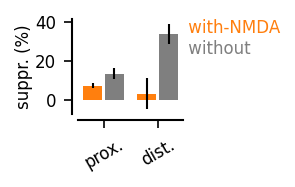

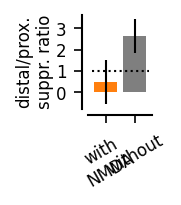

In [10]:
sparsening = 4.0
based_on = 'peak_efficacy_soma' # summary quantity to plot

fig1, ax1 = pt.figure(figsize=(.9, 1))
fig2, ax2 = pt.figure(figsize=(.7, 1))

Xs = []
for f, wNMDA in enumerate([True, False]):
    # suppression
    for iDistance in np.unique(sim.iDistance):
        params = dict(iDistance=iDistance, with_NMDA=wNMDA, synSubsamplingFraction=sparsening/100.)
        ax1.bar([iDistance+0.4*f], [100-np.mean(sim.get(based_on, params))],
               yerr=[np.std(sim.get(based_on, params))], color=COLORS[f], width=0.35)
    # suppression ratios
    pProx = dict(iDistance=0, with_NMDA=wNMDA, synSubsamplingFraction=sparsening/100.)
    pDist = dict(iDistance=1, with_NMDA=wNMDA, synSubsamplingFraction=sparsening/100.)
    X = (100-sim.get(based_on, pDist))/(100-sim.get(based_on, pProx))
    ax2.bar([f], [np.mean(X)], yerr=[np.std(X)], color=COLORS[f])#, width=0.5)
    pt.annotate(ax1, f*'\n'+LABELS[f], (1,1), va='top', color=COLORS[f])
    Xs.append(X)
    
print('\n statistics on the distal/prox ratios:\n')
print('- Wilcoxon:       ', stats.wilcoxon(*Xs))
print('- Paired t-test:  ', stats.ttest_rel(*Xs))

pt.set_plot(ax1, ylabel='suppr. (%)',
            xticks=0.2+np.arange(2), xticks_labels=['prox.', 'dist.'],
            xticks_rotation=30)

ax2.plot([-0.5,1.5], [1,1], 'k:')
pt.set_plot(ax2, ylabel='distal/prox.\nsuppr. ratio',
            xticks=np.arange(2), xticks_labels=['with\nNMDA', 'without'],
            yticks=[0,1,2,3], 
            xticks_rotation=30)

fig1.savefig('../../figures/detailed_model/cluster-suppression-prox-dist-MC.svg')
fig2.savefig('../../figures/detailed_model/cluster-suppression-ratio-MC.svg')

### NMDA Test
```
python clustered_input_stim.py -c Martinotti --nBranch 2 --sparsening 10 --suffix Test --test_NMDA
```

In [31]:
from parallel import Parallel

sim = Parallel(\
        filename='../../data/detailed_model/clusterStim_simTest_Martinotti.zip')

sim.load()

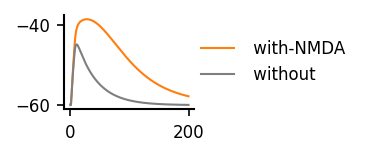

In [33]:
loc = 'soma'
sim.fetch_quantity_on_grid('real_%s' % loc, dtype=list)
dt = sim.fetch_quantity_on_grid('dt', dtype=float, return_last=True)

COLORS, LABELS = ['tab:orange', 'tab:grey'], [' with-NMDA', ' without']
    
fig, ax = pt.figure()
for f, label, color in zip([0,1], LABELS, COLORS):
    params = {'with_NMDA':(label==LABELS[0])}
    Vm = sim.get('real_%s' % loc, params)[0]
    ax.plot(np.arange(len(Vm))*dt, Vm, label=label, color=color)
ax.legend(loc=(1,0.2), frameon=False)